# Quantum Teleportation Algorithm (Protocol)

Quantum Teleportation Protocol, first proposed by Bennett et al. in 1993 [\[1\]](#ref-BBC93), is a foundational quantum communication method that enables the transfer of an arbitrary qubit state from one location (Alice) to another (Bob) using a combination of quantum entanglement and classical communication. It does not involve physically moving the qubit but rather transmitting its quantum information through shared entanglement.

Input: An arbitrary single-qubit state $\lvert \psi \rangle = \alpha \lvert 0 \rangle + \beta \lvert 1 \rangle$ to be teleported.

Resources: One shared Bell pair between Alice and Bob, and two bits of classical communication.

Output: Bob’s qubit reproduces the original state $\lvert \psi \rangle$ that was initially held by Alice.

Process: The protocol begins with the creation of an entangled Bell pair shared between Alice and Bob.
Alice entangles her qubit to be sent with her half of the Bell pair and performs mid-circuit measurements on her qubits.
The resulting classical bits are sent to Bob, who applies classically controlled corrections to reconstruct the original quantum state on his qubit.

Keywords: Quantum communication, Entanglement, Mid-circuit measurement, Hybrid quantum–classical systems, Information transfer.

## Algorithm Description

At the start Alice holds two qubits, one that she wishes to teleport (**`alice_qubit`**) and one that will be used during the protocol (**`bell_pair_qubit`**). 
$$
\lvert a \rangle = \alpha \lvert 0 \rangle + \beta \lvert 1 \rangle 
$$
$$\lvert p \rangle =\lvert 0 \rangle$$
Bob holds one qubit (**`bob_qubit`**).
$$\lvert b \rangle =\lvert 0 \rangle$$
##### 1. Bell State Creation
- Apply a **Hadamard (`H`)** gate to **`bell_pair_qubit`**.  
- Apply a **CNOT** gate with **`bell_pair_qubit`** as control and **`bob_qubit`** as target.  
These two qubits now form a Bell state.
$$
\lvert \psi \rangle_{pb} = \tfrac{1}{\sqrt{2}}(\lvert 00 \rangle_{pb} + \lvert 11 \rangle_{pb})
$$
##### 2. Entangling Alice’s Qubit with the Bell Pair
- Apply a **CNOT** gate from **`alice_qubit`** to **`bell_pair_qubit`**.  
- Apply a **Hadamard (`H`)** gate on **`alice_qubit`**.  
This step entangles Alice’s qubit with the Bell pair.
$$
\begin{split}
\lvert \psi \rangle_{apb} = \tfrac{1}{2} \big[ 
&\lvert 00 \rangle_{ap} \otimes (\alpha \lvert 0 \rangle_{b} + \beta \lvert 1 \rangle_{b}) \\
&+ \lvert 01 \rangle_{ap} \otimes (\alpha \lvert 1 \rangle_{b} + \beta \lvert 0 \rangle_{b}) \\
&+ \lvert 10 \rangle_{ap} \otimes (\alpha \lvert 0 \rangle_{b} - \beta \lvert 1 \rangle_{b}) \\
&+ \lvert 11 \rangle_{ap} \otimes (\alpha \lvert 1 \rangle_{b} - \beta \lvert 0 \rangle_{b}) 
\big]
\end{split}
$$
##### 3. Mid-Circuit Measurement
Measure **`alice_qubit`** and **`bell_pair_qubit`**.  
The measurement results will be later used to apply conditional corrections.
##### 4. Classically Controlled Corrections
After measuring **`alice_qubit`** and **`bell_pair_qubit`**, the system collapses to one of the four possible states shown above.
Each collapsed state differs from Alice’s original state by a known unitary transformation.
To recover the exact state that Alice initially held, appropriate correction operations must be applied to bob_qubit based on the measurement results.


Depending on the measurement outcomes:  
- If **`alice_qubit`** measures `0` and **`bell_pair_qubit`** measures `0` - do nothing.  
- If **`alice_qubit`** measures `0` and **`bell_pair_qubit`** measures `1`, apply **`X`** on **`bob_qubit`**.
- If **`alice_qubit`** measures `1` and **`bell_pair_qubit`** measures `0`, apply **`Z`** on **`bob_qubit`**.
- If **`alice_qubit`** measures `1` and **`bell_pair_qubit`** measures `1`, apply **`X`** on **`bob_qubit`** and then **`Z`** on **`bob_qubit`**.

$$
\begin{array}{ccl}
00 &\rightarrow& I(b) \\
01 &\rightarrow& X(b) \\
10 &\rightarrow& Z(b) \\
11 &\rightarrow& Z(b)X(b)
\end{array}
$$


These classically controlled gates complete the teleportation process, reconstructing Alice's original quantum state on **`bob_qubit`**.
$$
\lvert b \rangle = \alpha \lvert 0 \rangle + \beta \lvert 1 \rangle 
$$

A complete derivation is provided in the Technical Notes section at the end of this notebook.

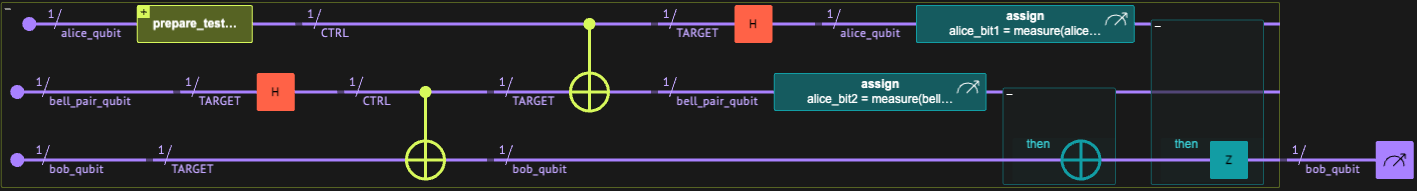
<center>
<figcaption align = "middle"> Figure 1. Quantum Teleportation algorithm </figcaption>
</center>

## Mid-Circuit Measurement

Mid-circuit measurement is a key feature in quantum computation that allows measuring a qubit **while the circuit is still running**, rather than only at the end of execution.  
This capability enables **classical feedback** - where measurement results influence subsequent quantum operations within the same program.

In Qmod, mid-circuit measurement is implemented through the `measure()` function.  
Unlike a final measurement, which collapses the qubit state at the end of a circuit, `measure()` can be invoked **within** a quantum function to extract partial information and conditionally control later operations.

The `measure()` function returns a Qmod classical variable (symbolic), representing the outcome of the measurement (either `0` or `1`).  
This symbolic value can be used to define conditional logic at circuit construction time, and is determined only during the actual quantum run of the program.


## How to Build the Algorithm with Classiq

We define a qunatum function `quantum_teleportation` that takes three qubits:
one for Alice (`alice_qubit`), one for Bob (`bob_qubit`), and one for their shared Bell pair (`bell_pair_qubit`).

### Classiq's implematation

In [1]:
from classiq import *


@qfunc
def quantum_teleportation(
    alice_qubit: QBit, bob_qubit: QBit, bell_pair_qubit: QBit
) -> None:

    # Step 1: Create Bell pair between bell_pair_qubit and Bob's qubit
    H(bell_pair_qubit)
    CX(bell_pair_qubit, bob_qubit)

    # Step 2: Alice performs Bell measurement on her qubits
    CX(alice_qubit, bell_pair_qubit)
    H(alice_qubit)

    # Step 3: Measure Alice's qubits to get classical bits
    alice_bit1 = measure(alice_qubit)
    alice_bit2 = measure(bell_pair_qubit)

    # Step 4: Apply corrections to Bob's qubit based on Alice's measurements
    if_(alice_bit2, lambda: X(bob_qubit))  # Apply X if bell_pair_qubit measurement is 1
    if_(alice_bit1, lambda: Z(bob_qubit))  # Apply Z if alice_qubit measurement is 1

**Alice state preperation:** This function defines Alice’s input state for teleportation.
It can be replaced with any other state-preparation routine as needed. We chose a simple superposition.

In [2]:
@qfunc
def prepare_test_state(q: QBit) -> None:
    H(q)

**Main function:** allocates the necessary qubits, prepares Alice’s qubit state,
and then calls the quantum teleportation function to perform the protocol.

In [3]:
@qfunc
def main(bob_qubit: Output[QBit]) -> None:

    alice_qubit = QBit()
    bell_pair_qubit = QBit()

    # Allocate qubits
    allocate(1, alice_qubit)
    allocate(1, bell_pair_qubit)
    allocate(1, bob_qubit)

    # Prepare the state to be teleported on Alice's qubit
    prepare_test_state(alice_qubit)

    # Perform teleportation
    quantum_teleportation(alice_qubit, bob_qubit, bell_pair_qubit)

**Create model and synthesize:** We create a quantum model using the defined main function, synthesize it into a circuit, and visualize it.

In [4]:
qprog = synthesize(main)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/34v9mcR9fWGjnK4pGsgLjDyMltJ


**Execute** the synthesized quantum program to observe Bob’s qubit after teleportation.

In [5]:
job = execute(qprog)
job.get_sample_result().dataframe

,bob_qubit,count,probability,bitstring
0,0,1065,0.52002,0
1,1,983,0.47998,1


The measured probabilities of Bob’s qubit closely match those of Alice’s initial state, indicating successful quantum teleportation of the superposition.


## Technical Notes

Start with Alice’s qubit in the state:
$$
\lvert a \rangle = \alpha \lvert 0 \rangle + \beta \lvert 1 \rangle 
$$

Bob’s and the Bell-pair qubits start in the state:
$$\lvert b \rangle =  \lvert p \rangle=\lvert 0 \rangle$$

After creating a bell state between $\lvert p \rangle$ and $\lvert b \rangle$
$$
\lvert \psi \rangle_{pb} = \tfrac{1}{\sqrt{2}}(\lvert 00 \rangle_{pb} + \lvert 11 \rangle_{pb})
$$
The total state is now:  
$$
\lvert \psi \rangle_{apb} = (\alpha \lvert 0 \rangle_{a} + \beta \lvert 1 \rangle_{a} )\otimes(\tfrac{1}{\sqrt{2}}(\lvert 00 \rangle_{pb} + \lvert 11 \rangle_{pb}))=\tfrac{\alpha}{\sqrt{2}}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{\sqrt{2}}\lvert 011 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 100 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 111 \rangle_{apb}
$$
After applying CX(a,p):  
$$
\lvert \psi \rangle_{apb} = \tfrac{\alpha}{\sqrt{2}}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{\sqrt{2}}\lvert 011 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 110 \rangle_{apb}+\tfrac{\beta}{\sqrt{2}}\lvert 101 \rangle_{apb}
$$

Applying H(a):
$$
\lvert \psi \rangle_{apb} = \tfrac{\alpha}{2}\lvert 000 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 100 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 011 \rangle_{apb}+\tfrac{\alpha}{2}\lvert 111 \rangle_{apb}+\tfrac{\beta}{2}\lvert 010 \rangle_{apb}-\tfrac{\beta}{2}\lvert 110 \rangle_{apb}+\tfrac{\beta}{2}\lvert 001 \rangle_{apb}-\tfrac{\beta}{2}\lvert 101 \rangle_{apb}
$$
Simplify:
$$
\begin{split}
\lvert \psi \rangle_{apb} = \tfrac{1}{2} \big[ 
&\lvert 00 \rangle_{ap} \otimes (\alpha \lvert 0 \rangle_{b} + \beta \lvert 1 \rangle_{b}) \\
&+ \lvert 01 \rangle_{ap} \otimes (\alpha \lvert 1 \rangle_{b} + \beta \lvert 0 \rangle_{b}) \\
&+ \lvert 10 \rangle_{ap} \otimes (\alpha \lvert 0 \rangle_{b} - \beta \lvert 1 \rangle_{b}) \\
&+ \lvert 11 \rangle_{ap} \otimes (\alpha \lvert 1 \rangle_{b} - \beta \lvert 0 \rangle_{b}) 
\big]
\end{split}
$$
The classical correction operations based on Alice’s and the Bell-pair measurement results are:
$$
\begin{array}{ccl}
00 &\rightarrow& I(b) \\
01 &\rightarrow& X(b) \\
10 &\rightarrow& Z(b) \\
11 &\rightarrow& Z(b)X(b)
\end{array}
$$

This function is creating a Qmod-native version of this code:

In [6]:
write_qmod(main, "quantum_teleportation")

## References

<a id='ref-BBC93'>[1]</a>: C. H. Bennett, G. Brassard, C. Crépeau, R. Jozsa, A. Peres, and W. K. Wootters, “Teleporting an unknown quantum state via dual classical and Einstein–Podolsky–Rosen channels,” Physical Review Letters, 70, 1895 (1993). DOI:10.1103/PhysRevLett.70.1895

<a id='QTWiki'>[2]</a>: [Qunatum Teleportation (Wikipedia)](https://en.wikipedia.org/wiki/Quantum_teleportation)
